In [1]:
# --------
# TASK 2 (ML eng. only)
# --------

# Imagine the digits in the test set of the MNIST dataset
# (http://yann.lecun.com/exdb/mnist/) got cut in half vertically and shuffled
# around. Implement a way to restore the original test set from the two halves,
# whilst maximising the overall matching accuracy.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import idx2numpy
from random import shuffle

### Introduction

My approach to this task can be summarized as follows:
1. Create a convolutional neural network for recognition of unaltered MNIST written digits.
2. Splitting the image into halves.
3. Create another network for generating right halves from left halves.
4. Splitting and shuffling the test set halves (halves and their labels remain in the same order in resulting data, so that we can check how the accuracy of matching and predictions).
5. Re-matching halves and predicting number from the joined images using the original model from point 1.

### Load the data

(please first unzip all of the archives downloaded from the Yann LeCun's website)

In [3]:
X_train = idx2numpy.convert_from_file("mnist/train-images-idx3-ubyte").astype(np.float32)
y_train = idx2numpy.convert_from_file("mnist/train-labels-idx1-ubyte").astype(np.float32)
X_test = idx2numpy.convert_from_file("mnist/t10k-images-idx3-ubyte").astype(np.float32)
y_test = idx2numpy.convert_from_file("mnist/t10k-labels-idx1-ubyte").astype(np.float32)

In [4]:
# Make categorical y arrays for the purposes of training
y_train_cat = tf.keras.utils.to_categorical(y_train, 10)
y_test_cat = tf.keras.utils.to_categorical(y_test, 10)

In [5]:
# Normalize
X_train = X_train / 255
X_test = X_test / 255

Imports for constructing neural networks

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Reshape, Conv2DTranspose, Cropping2D
from tensorflow.keras.callbacks import EarlyStopping

### Build a model for digit recognition

A simple CNN

In [7]:
def create_model():
    model = Sequential()
    model.add(Conv2D(50, (3,3), activation="relu", input_shape=(28,28,1)))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(50, (3,3), activation="relu", input_shape=(28,28,1)))
    model.add(MaxPool2D((2,2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")
    return model

In [8]:
model = create_model()

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 50)        500       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 50)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 50)        22550     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 50)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1250)              0         
                                                                 
 dropout (Dropout)           (None, 1250)              0

In [10]:
# Early stop callback for training
early_stop = EarlyStopping(monitor="val_loss", patience=3)

Training the model

In [11]:
model.fit(X_train.reshape(-1,28,28,1), y_train_cat, epochs=30, 
          validation_data=[X_test.reshape(-1,28,28,1), y_test_cat],
         callbacks=early_stop)

Epoch 1/30


2022-06-27 15:38:44.381253: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1875/1875 [==============================] - 18s 10ms/step - loss: 0.1734 - accuracy: 0.9470 - val_loss: 0.0484 - val_accuracy: 0.9861
Epoch 2/30
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0610 - accuracy: 0.9817 - val_loss: 0.0383 - val_accuracy: 0.9869
Epoch 3/30
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0465 - accuracy: 0.9857 - val_loss: 0.0328 - val_accuracy: 0.9894
Epoch 4/30
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0383 - accuracy: 0.9879 - val_loss: 0.0264 - val_accuracy: 0.9907
Epoch 5/30
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0320 - accuracy: 0.9897 - val_loss: 0.0288 - val_accuracy: 0.9906
Epoch 6/30
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0274 - accuracy: 0.9911 - val_loss: 0.0305 - val_accuracy: 0.9901
Epoch 7/30
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0238 - accuracy: 0.9926 - val_loss: 0.0305 - val_accura

Saving the model so that we don't have to train it every time

In [12]:
model.save("task2-model.h5")

In [13]:
def predict_number(img):
    """
    Predict number from image (full).
    """
    return model.predict(img.reshape(-1,28,28,1)).argmax()

### Separation and matching of halves in train and test set

In [14]:
# split into halves
X_train_left = X_train[:,:,:14]
X_train_right = X_train[:,:,14:]
X_test_left = X_test[:,:,:14]
X_test_right = X_test[:,:,14:]

Creating a model for generating right half from left half

In [15]:
def create_half_model():
    model = Sequential()
    model.add(Conv2D(60, (3, 3), input_shape=(28,14,1), activation="relu", padding="same"))
    model.add(MaxPool2D((2, 2), padding="same"))
    model.add(Conv2D(60, (3, 3), input_shape=(28,14,1), activation="relu", padding="same"))
    model.add(MaxPool2D((2, 2), padding="same"))
    model.add(Flatten())
    model.add(Dense(25, activation="relu"))
    model.add(Dense(1680, activation="relu"))
    model.add(Reshape((7,4,60)))
    model.add(Conv2DTranspose(60, (3, 3), strides=2, activation="relu", padding="same"))
    model.add(Conv2DTranspose(60, (3, 3), strides=2, activation="relu", padding="same"))
    model.add(Conv2D(1, (3, 3), activation="sigmoid", padding="same"))
    model.add(Cropping2D(cropping=(0, 1)))
    model.compile(optimizer="adam", loss="mse", metrics="accuracy")
    return model

In [16]:
left_to_right = create_half_model()

In [17]:
left_to_right.fit(X_train_left.reshape(-1,28,14,1), X_train_right.reshape(-1,28,14,1), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0419 - accuracy: 0.7820
Epoch 2/10
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0317 - accuracy: 0.7858
Epoch 3/10
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0299 - accuracy: 0.7868
Epoch 4/10
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0289 - accuracy: 0.7872
Epoch 5/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0283 - accuracy: 0.7876
Epoch 6/10
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0278 - accuracy: 0.7878
Epoch 7/10
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0274 - accuracy: 0.7880
Epoch 8/10
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0270 - accuracy: 0.7882
Epoch 9/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0267 - accuracy: 0.7883
Epoch 10/10
1875/1875 [==============================] - 39s 21m

In [18]:
left_to_right.save("task2-l2r.h5")

Let's see how it works

In [19]:
sample = 51

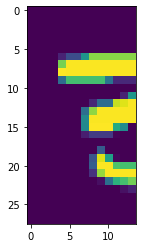

In [20]:
plt.imshow(X_test_left[sample])

In [21]:
def predict(half):
    """
    Generate right half from left half.
    """
    input_array = half.reshape(-1,28,14,1)
    return left_to_right.predict(input_array).reshape(28,14)

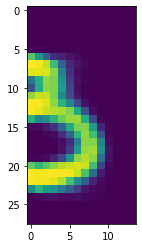

In [22]:
plt.imshow(predict(X_test_left[sample]))

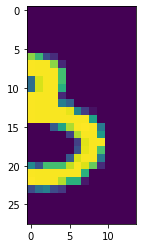

In [23]:
plt.imshow(X_test_right[sample])

Visually, it does a decent job.

Now we merge and shuffle the halves into a new set with 10000 * 2 elements.

Labels remain ordered the same way as halves so that we can check the results.

In [24]:
shuffled_x_test = np.concatenate([X_test_left.copy(), X_test_right.copy()], 0)
shuffled_y_test = np.concatenate([y_test.copy(), y_test.copy()], 0)
indices = list(range(20000))
shuffle(indices)
shuffled_x_test = shuffled_x_test[indices]
shuffled_y_test = shuffled_y_test[indices]

And here I create classes for re-matching the halves.

In my approach, I do not remove the matched right halves from the pool. This means that some new images will have identical right halves, while some right halves will not be used. I found that this leads to better overall agreement between original labels and new predictions.

In [25]:
def predict(half):
    """
    Generate right half from left half.
    """
    input_array = half.reshape(-1,28,14,1)
    return left_to_right.predict(input_array).reshape(28,14)


def check_im_match(pred, test):
    """
    Evaluate the extent to which two image halves match (simple RMSE).
    """
    dist = test - (pred / test.max())
    return np.sqrt((dist**2).sum(-1).sum(-1))


def which_half(half):
    """
    Function to determine whether the given half is left or right.
    Density of pixel brightness on each side of a given half-array is evaluated.
    """
    left_side = half[:,:3].sum()
    right_side = half[:,-3:].sum()
    if left_side > right_side:
        return "right"
    else:
        return "left"


class SeparateTestHalves:
    """
    Class for separating the shuffled data into left and right halves.
    """
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.left_x, self.right_x, self.left_y, self.right_y = self.get_halves()
    
    def get_halves(self):
        halves_filter = np.array([which_half(half) for half in self.x])
        leftind = np.argwhere(halves_filter == "left")
        rightind = np.argwhere(halves_filter == "right")
        left_x = self.x[leftind].reshape(-1,28,14)
        right_x = self.x[rightind].reshape(-1,28,14)
        left_y = self.y[leftind].reshape(-1)
        right_y = self.y[rightind].reshape(-1)
        return left_x, right_x, left_y, right_y


class MatchTestHalves(SeparateTestHalves):
    """
    Extension of the separating class, with match method for joining the halves
    and evaluating accuracy of joining halves and of predictions from joined images.
    """
    
    def match(self):
        """
        Returns a list of tuples like so:
        (merged img, left half label, right half label, new predicted label)
        """
        matches = []
        for n in range(self.left_x.shape[0]):
            left = self.left_x[n]
            prediction = predict(left)
            scores = check_im_match(prediction, self.right_x)
            match_ind = np.argwhere(scores == scores.min())
            joined_img = np.concatenate([left, self.right_x[match_ind].reshape(28,14)],1)
            left_label = self.left_y[n]
            right_label = self.right_y[match_ind].sum() # sum is here to extract the scalar
            prediction = predict_number(joined_img)
            matches.append((joined_img, left_label, right_label, prediction))
        
        return matches

In [26]:
halves = MatchTestHalves(shuffled_x_test, shuffled_y_test)

In [27]:
matched_imgs = halves.match()

This took 8 minutes on my machine (2020 MacBook Pro M1), which is certainly not ideal.

In [53]:
sample = matched_imgs[0]

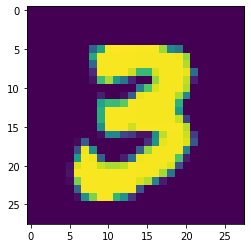

In [54]:
plt.imshow(sample[0])

#### Original test set accuracy from the model trained at the beginning

In [55]:
original_test_predictions = model.predict(X_test.reshape(-1,28,28,1)).argmax(1)
(original_test_predictions == y_test).mean()

0.9908

In [56]:
(original_test_predictions == y_test).mean()

0.9908

#### Agreeement between labels of left and right halves

In [57]:
halves_label_match = np.array([img[1] == img[2] for img in matched_imgs])
halves_label_match.mean()

0.8916

#### Agreement between left side label and prediction from re-joined image

In [58]:
pred_label_match = np.array([img[1] == img[3] for img in matched_imgs])
pred_label_match.mean()

0.9518

### Summary

Overall the test set is recreated, although not quite accurately. I think the match between labels of left and right sides is less important than the agreement between original left side labels and the labels predicted from the regenerated image. That is because ultimately we are interested in the recovery of the test set.
Room for improvement:
- finding a better method for evaluating similarity between predicted and matches halves;
- better scaling of the matching process - 7 minutes is, I think, quite a long time for processing 10000 datapoints, although the splitting into halves is a destructive process, so recovery of the information is not that easy;
- a better model for recognition of entire digits can certainly be constructed, but I decided not to focus on that here